In [0]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_olivetti_faces

In [3]:
(x_train,y_train) , (x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_train=x_train.reshape(60000,28,28,1).astype('float32')/255.0
x_test=x_test.reshape(10000,28,28,1).astype('float32')/255.0
x_train[x_train>=.5]=1.
x_train[x_train<.5]=0.
x_test[x_test>=.5]=1.
x_test[x_test<.5]=0.

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
epochs=10
batch_size=16
dataset=tf.data.Dataset.from_tensor_slices((x_train,x_train)).batch(16).repeat()


In [0]:
h_img,w_img=224,224

In [25]:
def conv_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  layer=tf.keras.layers.Conv2D(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  return layer
  
def conv_transpose_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  layer=tf.keras.layers.Conv2DTranspose(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  return layer


def model(input_shape,latent_dim):
  #Encoder 
  model_input=tf.keras.Input(input_shape)
  layer=conv_layer(model_input,32,3)
  layer=conv_layer(layer,16,3,strides=2)
  layer=conv_layer(layer,32,3,strides=2)
  shape_before_flatten=layer.shape
  layer=tf.keras.layers.Flatten()(layer)
  mean=tf.keras.layers.Dense(latent_dim)(layer)
  var=tf.keras.layers.Dense(latent_dim)(layer)
  encoder_model=tf.keras.models.Model(model_input,[mean,var])
  
  #Decoder
  decoder_input=tf.keras.Input((latent_dim,))
  layer=tf.keras.layers.Dense(np.prod(shape_before_flatten[1:]),\
                              activation='relu')(decoder_input)
  layer=tf.keras.layers.Reshape(target_shape=shape_before_flatten[1:])(layer)
  layer=conv_transpose_layer(layer,32,3,strides=2)
  layer=conv_transpose_layer(layer,16,3,strides=2)
  layer=conv_transpose_layer(layer,1,3,activation='sigmoid')
  decoder_model=tf.keras.models.Model(decoder_input,layer)  
 
  #Reparameterization Trick
  mean,var=encoder_model(model_input)
  epsilon=tf.random.normal(shape=(tf.shape(var)[0],
                                  tf.shape(var)[1]))
  z=mean+tf.exp(var)*epsilon
  model_out=decoder_model(z)
  model=tf.keras.models.Model(model_input,model_out)
  model.summary()

  #KL div loss
  kl_loss= 0.5 * tf.reduce_mean(tf.square(mean) - 1 - var + tf.exp(var))
  #Reconstruction loss
  reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(model_input),
                                            tf.keras.backend.flatten(model_out))
  vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
  model.add_loss(vae_loss)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.01))
  return model,decoder_model

input_shape=(28,28,1)
latent_dim=2
vae_model,decoder_model=model(input_shape,latent_dim)


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_6 (Model)                 [(None, 2), (None, 2 15860       input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape_6 (TensorFlow [(2,)]               0           model_6[1][1]                    
__________________________________________________________________________________________________
tf_op_layer_Shape_7 (TensorFlow [(2,)]               0           model_6[1][1]                    
____________________________________________________________________________________________

In [0]:
callback=[(tf.keras.callbacks.ModelCheckpoint(filepath='/content/mnist_model.h5',
                                            patience=0, verbose=0))]
vae_model.fit(dataset,epochs=epochs,callbacks=callback,steps_per_epoch=(len(x_train)//batch_size))

Epoch 1/10
3750/3750 [==============================] - 153s 41ms/step - loss: 0.2654
Epoch 2/10
3750/3750 [==============================] - 147s 39ms/step - loss: 0.2639
Epoch 3/10
3750/3750 [==============================] - 151s 40ms/step - loss: 0.2640
Epoch 4/10
1076/3750 [=======>......................] - ETA: 1:45 - loss: 0.2645

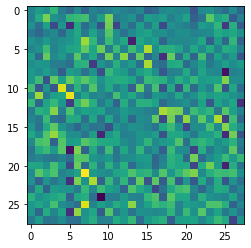

In [21]:
#Testing
num_example=1
test_example=tf.random.normal(shape=[num_example,latent_dim])
pred=decoder_model.predict(test_example)
import matplotlib.pyplot as plt
plt.imshow(np.reshape(pred,(28,28)))
plt.show()


In [23]:
pred=vae_model.predict(x_test[0])
import matplotlib.pyplot as plt
plt.imshow(np.reshape(pred,(28,28)))
plt.show()


ValueError: ignored